In [1562]:
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, accuracy_score

In [1563]:
#https://towardsdatascience.com/timeseries-data-munging-lagging-variables-that-are-distributed-across-multiple-groups-86e0a038460c
def lag_by_group(key, value_df):
    df = value_df.assign(group = key) # this pandas method returns a copy of the df, with group columns assigned the key value
    return (df.sort_values(by=["Date"], ascending=True).set_index(["Date"]).shift(12)) # the parenthesis allow you to chain methods and avoid intermediate variable assignment

In [1564]:
plt.style.use('fivethirtyeight')

In [1565]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Preprocessed_Data')
NO2_df = pd.read_csv('NO2.csv', index_col = 0)
SSM_df = pd.read_csv('SSM.csv', index_col = 0)
Soil_Temp_df = pd.read_csv('Soil_Temperature.csv', index_col = 0)
Ozon_df =  pd.read_csv('Ozon.csv', index_col = 0)
PM25_df = pd.read_csv('PM2.5.csv', index_col = 0)
Crops_df = pd.read_csv('crops_dummies.csv', index_col = 0)
FRP_df = pd.read_csv('frp_mandals.csv', index_col = 0)
Croparea_df = pd.read_csv('mandals_cropsarea.csv', index_col = 0)


In [1566]:
Croparea_df_selected = pd.melt(Croparea_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name'], value_vars=Croparea_df.columns[3:])
Croparea_df_selected = Croparea_df_selected.rename(columns={"variable": 'Year', 'value': 'Crops'})
Croparea_df_selected['Year'] = Croparea_df_selected['Year'].astype(int)

In [1567]:
FRP_df.columns = ['index', 'Date', 'FRP (MW)']
FRP_df_selected = FRP_df[FRP_df['Date']<'2019-01-01']

In [1568]:
SSM_df_selected = pd.melt(SSM_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=SSM_df.columns[:-43])
SSM_df_selected = SSM_df_selected.rename(columns={"variable": 'Date', 'value': 'SSM'})


In [1569]:
NO2_df_selected = pd.melt(NO2_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=NO2_df.columns[:-36])
NO2_df_selected = NO2_df_selected.rename(columns={"variable": 'Date', 'value': 'NO2 (Dobson Units)'})

In [1570]:
Soil_Temp_df_selected = pd.melt(Soil_Temp_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=Soil_Temp_df.columns[:-36])
Soil_Temp_df_selected = Soil_Temp_df_selected.rename(columns={"variable": 'Date', 'value': 'Soil Temperature (Celcius)'})


In [1571]:
Ozon_df_selected = pd.melt(Ozon_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=Ozon_df.columns[:-36])
Ozon_df_selected = Ozon_df_selected.rename(columns={"variable": 'Date', 'value': 'Ozon (Billion Molecules/mm2)'})

In [1572]:
PM25_df_selected = pd.melt(PM25_df, id_vars=['index', 'Mandal_Nam', 'Dist_Name', 'geometry'], value_vars=PM25_df.columns[:-24])
PM25_df_selected = PM25_df_selected.rename(columns={"variable": 'Date', 'value': 'PM2.5 (ug/m3)'})

In [1573]:
len(FRP_df_selected), len(SSM_df_selected), len(NO2_df_selected), len(Soil_Temp_df_selected), len(Ozon_df_selected), len(PM25_df_selected)

(24432, 26640, 28416, 28416, 28416, 28416)

In [1574]:
total = pd.concat([NO2_df_selected, Soil_Temp_df_selected['Soil Temperature (Celcius)'], Ozon_df_selected['Ozon (Billion Molecules/mm2)'], PM25_df_selected['PM2.5 (ug/m3)']], axis=1)
total = pd.merge(total, SSM_df_selected[['index', 'Date', 'SSM']], on=['index', 'Date'], how = 'left')
total = pd.merge(total, FRP_df_selected[['index', 'Date', 'FRP (MW)']], on=['index', 'Date'], how = 'left')
total['FRP (MW)'] = total['FRP (MW)'].fillna(0)

total['Date'] =  pd.to_datetime(total['Date'])
total['Year'] = (total['Date']).dt.year
total['Month'] = (total['Date']).dt.month

total['Year'] = total['Year'].astype(int)
total['Month'] = total['Month'].astype(int)

total = pd.merge(total, Croparea_df_selected[['index', 'Year', 'Crops']], on=['index', 'Year'], how = 'left')

In [1575]:
total['Kharif'] = 0
total['Rabi'] = 0

for i in range(0, len(total)):
    if (total['Month'].iloc[i] == 5) | (total['Month'].iloc[i] == 6) | (total['Month'].iloc[i] == 7):
        total['Rabi'].iloc[i] = 1
    elif (total['Month'].iloc[i] == 9) | (total['Month'].iloc[i] == 10):
        total['Kharif'].iloc[i] = 1 

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [1583]:
crops = Crops_df.columns[4:-2]

In [1584]:
total = total.merge(Crops_df, on=['index', 'Dist_Name', 'Mandal_Nam', 'Year', 'Kharif', 'Rabi'], how='outer')
total[crops] = total[crops].fillna(0)

In [1585]:
total_df = total[['index', 'Date',
       'NO2 (Dobson Units)', 'Soil Temperature (Celcius)', 'SSM',
       'Ozon (Billion Molecules/mm2)', 'PM2.5 (ug/m3)', 'FRP (MW)']].groupby(["index"])
dflist = [lag_by_group(g, total_df.get_group(g)) for g in total_df.groups.keys()]
lagged_12months = pd.concat(dflist, axis=0).reset_index()

In [1586]:
lagged_12months = lagged_12months[lagged_12months['Date']>='2016-01-01']
lagged_12months = lagged_12months.sort_values(by=['Date', 'index'])
lagged_12months.columns = ['Date', 'index', 'NO2_12lag', 'Soil_Temp_12lag',
       'SSM_12lag', 'Ozon_12lag', 'PM2.5_12lag', 'FRP_12lag', 'group']
lagged_12months['index'] = lagged_12months['index'].astype(int)

In [1587]:
total = total[total['Date']>='2016-01-01']
total = total.sort_values(by=['Date', 'index'])

In [1588]:
total['NO2_12lag'] = lagged_12months['NO2_12lag']
total['Soil_Temp_12lag'] = lagged_12months['Soil_Temp_12lag']
total['SSM_12lag'] = lagged_12months['SSM_12lag']
total['Ozon_12lag'] = lagged_12months['Ozon_12lag']
total['PM2.5_12lag'] = lagged_12months['PM2.5_12lag']
total['FRP_12lag'] = lagged_12months['FRP_12lag']

In [1589]:
print('Amount of missing values: ' + str(total.isnull().sum().sum()))

Amount of missing values: 33620


In [1590]:
total = total.sort_values(by=['Mandal_Nam','Date'])
total = total.dropna()
len(total)

14397

In [1591]:
train = total[total['Date']<'2018']
test = total[total['Date']>='2018']
print(len(train), len(test))

9671 4726


In [1592]:
train = train.reset_index()
test = test.reset_index()

del train['level_0']
del test['level_0']

In [1593]:
train.columns

Index(['index', 'Mandal_Nam', 'Dist_Name', 'geometry', 'Date',
       'NO2 (Dobson Units)', 'Soil Temperature (Celcius)',
       'Ozon (Billion Molecules/mm2)', 'PM2.5 (ug/m3)', 'SSM', 'FRP (MW)',
       'Year', 'Month', 'Crops', 'Kharif', 'Rabi', 'Bengal Gram', 'Castor',
       'Chillies', 'Cotton', 'Green Gram', 'Groundnut', 'Jowar', 'Maize',
       'Onion', 'Paddy', 'Red Gram', 'Sesamum', 'Soyabean', 'Sugarcane',
       'Sunflower', 'NO2_12lag', 'Soil_Temp_12lag', 'SSM_12lag', 'Ozon_12lag',
       'PM2.5_12lag', 'FRP_12lag'],
      dtype='object')

In [1625]:
feature_list = ['Kharif', 'Rabi', 'Soil_Temp_12lag', 'SSM_12lag', 'Crops']
for crop in crops:
    feature_list.append(crop)
predictors = ['NO2 (Dobson Units)', 'PM2.5 (ug/m3)']

In [1595]:
normalized_columns = ['NO2 (Dobson Units)', 'Soil Temperature (Celcius)', 'SSM',
       'Ozon (Billion Molecules/mm2)', 'PM2.5 (ug/m3)', 'FRP (MW)', 'Crops', 'NO2_12lag',
       'Soil_Temp_12lag', 'SSM_12lag', 'Ozon_12lag', 'PM2.5_12lag',
       'FRP_12lag', 'Year', 'Month']


non_normalized_columns = []

for i in train.columns:
       if i not in normalized_columns:
              non_normalized_columns.append(i)


In [1596]:
scaler_train = MinMaxScaler() 
scaled_values_train = scaler_train.fit_transform(train[normalized_columns]) 
train_scaled = pd.DataFrame(scaled_values_train, columns = normalized_columns)
train_scaled = pd.concat([train[non_normalized_columns], train_scaled[normalized_columns]], axis=1)

scaler_test = MinMaxScaler() 
scaled_values_test = scaler_test.fit_transform(test[normalized_columns]) 
test_scaled = pd.DataFrame(scaled_values_test, columns = normalized_columns)
test_scaled = pd.concat([test[non_normalized_columns], test_scaled[normalized_columns]], axis=1)


In [1597]:
def subsets (l):
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list


# Linear Regression

In [1598]:
parameter_scores_LR = []

for predic in predictors:
    for features in subsets(feature_list):
        
        scaler_train = MinMaxScaler()
        scaler_test = MinMaxScaler() 

        x_train = np.array(train[features])
        x_test = np.array(test[features])
        x_train_scaled = scaler_train.fit_transform(x_train) 
        x_test_scaled = scaler_test.fit_transform(x_test) 

        y_train = np.array(train[predic])
        y_test = np.array(test[predic])
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        y_train_scaled = scaler_train.fit_transform(y_train) 
        y_test_scaled = scaler_test.fit_transform(y_test) 

        model = LinearRegression().fit(x_train_scaled, y_train_scaled)

        #Make a prediction on the test data
        predictions_scaled = model.predict(x_test_scaled)
        predictions_scaled = predictions_scaled.reshape(1,-1)
        predictions = scaler_test.inverse_transform(predictions_scaled)
        predictions = predictions.reshape(predictions.shape[1],)
        #Calculate mean absolute error
        MAE = mean_absolute_error(y_test_scaled, predictions)

        #Accuracy
        errors = abs(predictions - y_test)
        mape = 100 * (errors / y_test)
        # Calculate and display accuracy
        accuracy = 100 - np.mean(mape)


        parameter_scores_LR.append((MAE, accuracy, predic, features))

In [1599]:
parameter_scores_LR.sort(key=lambda x: x[0])
print(parameter_scores_LR[0])

(42.652621668764915, 59.89580174348382, 'PM2.5 (ug/m3)', ['Bengal Gram', 'Castor', 'Chillies', 'Cotton', 'Green Gram', 'Groundnut', 'Jowar', 'Maize'])


In [1600]:
parameter_scores_LR

[(42.652621668764915,
  59.89580174348382,
  'PM2.5 (ug/m3)',
  ['Bengal Gram',
   'Castor',
   'Chillies',
   'Cotton',
   'Green Gram',
   'Groundnut',
   'Jowar',
   'Maize']),
 (42.656841214096616,
  59.865577236977934,
  'PM2.5 (ug/m3)',
  ['Bengal Gram',
   'Castor',
   'Chillies',
   'Cotton',
   'Green Gram',
   'Groundnut',
   'Jowar',
   'Maize',
   'Onion']),
 (42.66289492787143,
  59.788546015419605,
  'PM2.5 (ug/m3)',
  ['Soil_Temp_12lag',
   'SSM_12lag',
   'Crops',
   'Month',
   'Bengal Gram',
   'Castor',
   'Chillies',
   'Cotton',
   'Green Gram',
   'Groundnut',
   'Jowar',
   'Maize']),
 (42.6644664244618,
  59.82838884850496,
  'PM2.5 (ug/m3)',
  ['Month',
   'Bengal Gram',
   'Castor',
   'Chillies',
   'Cotton',
   'Green Gram',
   'Groundnut',
   'Jowar',
   'Maize']),
 (42.66745519340902,
  59.75967946591842,
  'PM2.5 (ug/m3)',
  ['Soil_Temp_12lag',
   'SSM_12lag',
   'Crops',
   'Month',
   'Bengal Gram',
   'Castor',
   'Chillies',
   'Cotton',
   'Green Gra

In [1601]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')
parameter_scores_LR = np.array(parameter_scores_LR)
np.save('LR_parameters_scores.npy', parameter_scores_LR)

<ipython-input-1601-85b9d92a1fe2>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  parameter_scores_LR = np.array(parameter_scores_LR)


In [1602]:
optimal_features = ['Soil_Temp_12lag', 'SSM_12lag', 'Crops', 'Year']
optimal_predictor = 'NO2 (Dobson Units)'

x_train_scaled = np.array(train_scaled[optimal_features])
x_test_scaled = np.array(test_scaled[optimal_features])
#x_test_scaled = x_test_scaled.reshape(1, -1)

y_train_scaled = np.array(train_scaled[optimal_predictor])
y_test_scaled = np.array(test_scaled[optimal_predictor])
#y_test_scaled = y_test_scaled.reshape(1, -1)

In [1603]:
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler() 

x_train = np.array(train[optimal_features])
x_test = np.array(test[optimal_features])
x_train_scaled = scaler_train.fit_transform(x_train) 
x_test_scaled = scaler_test.fit_transform(x_test) 

y_train = np.array(train[optimal_predictor])
y_test = np.array(test[optimal_predictor])
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train_scaled = scaler_train.fit_transform(y_train) 
y_test_scaled = scaler_test.fit_transform(y_test) 

In [1604]:
model = LinearRegression().fit(x_train_scaled, y_train_scaled)

In [1605]:
r_sq = model.score(x_train_scaled, y_train_scaled)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"Slopes:")
for i in range(0, len(optimal_features)):
    print(optimal_features[i] + ': '+ str(model.coef_[0][i]))

coefficient of determination: 0.037259409610004623
intercept: [0.28401453]
Slopes:
Soil_Temp_12lag: 0.014312158659323544
SSM_12lag: 0.005092207451282952
Crops: -0.1099517107786875
Year: 0.02253916596549795


In [1606]:
y_pred_scaled = model.predict(x_test_scaled)
y_pred_scaled = y_pred_scaled.reshape(1, -1)
y_pred = scaler_test.inverse_transform(y_pred_scaled)


test['y_pred'] = y_pred[0]

In [1607]:
errors = abs(y_pred - y_test)

print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Average NO2 (Dobson Units): ' + str(y_test.mean()))

Mean Absolute Error: 78.35
Average NO2 (Dobson Units): 238.25285812252366


In [1608]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 63.45 %.


In [1609]:
mandal_name = 'Yellandu'

mandal_y_test = np.array(test[test['Mandal_Nam']==mandal_name][optimal_predictor])
mandal_x_test = np.array(test[test['Mandal_Nam']==mandal_name][feature_list])

mandal_y_pred_test = np.array(test[test['Mandal_Nam']==mandal_name]['y_pred'])

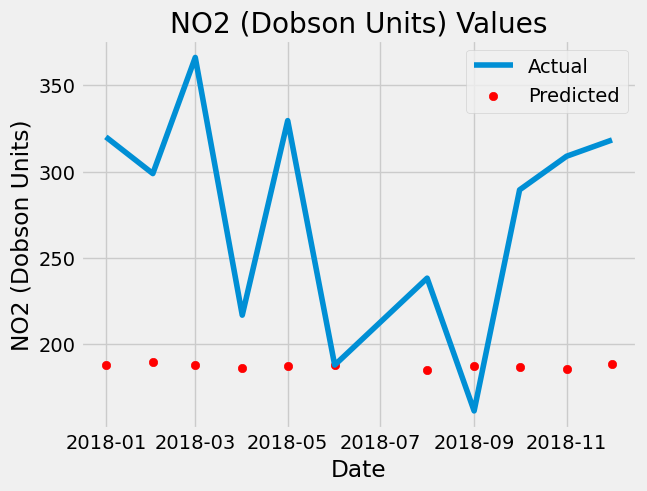

In [1610]:
dates = test[test['Mandal_Nam']==mandal_name]['Date']

plt.plot(dates, mandal_y_test, label = 'Actual')
plt.scatter(dates, mandal_y_pred_test, label='Predicted', color = 'red')
plt.legend()
plt.title(optimal_predictor + ' Values')
plt.ylabel(optimal_predictor)
plt.xlabel('Date')
plt.show()

# Random Forest
###### https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [945]:
#MAE_test = []
#MAE_train = []

#depth = [5, 10, 15, 20, 25]

#for maxdepth in depth:
#    if maxdepth%2==0:
#        print(maxdepth)
#    rf_trial = RandomForestRegressor(n_estimators = 64, random_state = 42, max_depth = maxdepth) 
#    rf_trial.fit(x_train, y_train)
#    predictions_train = rf_trial.predict(x_train)
#    predictions_test = rf_trial.predict(x_test)
#    MAE_train.append(round(np.mean(abs(predictions_train - y_train)), 2))
#    MAE_test.append(round(np.mean(abs(predictions_test - y_test)), 2))



#plt.plot(depth, MAE_train, label='Train')
#plt.plot(depth, MAE_test, label='Test', color='red')
#plt.title('MAE Based on the Max Tree Depth')
#plt.xlabel('Max Tree Depth')
#plt.ylabel('MAE ')
#plt.legend()
#plt.show()


In [1626]:
depth_min = 3
depth_max = 15
n_estimators_min = 64
n_estimators_max = 65
n_estimators = [128]

In [1627]:
#Investigate every subset of explanatory variables
parameter_scores = []

for predic in predictors:

    for num_trees in n_estimators:

        for depth in range(depth_min, depth_max):

            for features in subsets(feature_list):
                    
                x_train = np.array(train[features])
                x_test = np.array(test[features])

                y_train = np.array(train[predic])
                y_test = np.array(test[predic])

                clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0)

                #Fit to the training data
                clf.fit(x_train, y_train)

                #Make a prediction on the test data
                predictions = clf.predict(x_test)

                #Calculate mean absolute error
                MAE = mean_absolute_error(y_test, predictions)

                #Accuracy
                errors = abs(predictions - y_test)
                mape = 100 * (errors / y_test)
                # Calculate and display accuracy
                accuracy = 100 - np.mean(mape)


                parameter_scores.append((MAE, accuracy, depth, num_trees, predic, features))

In [1628]:
parameter_scores.sort(key=lambda x: x[0])
print(parameter_scores[0])

(7.139011176541303, 78.76802708006134, 13, 128, 'PM2.5 (ug/m3)', ['Kharif', 'Rabi', 'Soil_Temp_12lag', 'SSM_12lag', 'Crops', 'Bengal Gram', 'Castor', 'Chillies', 'Cotton', 'Green Gram', 'Groundnut', 'Jowar', 'Maize', 'Onion', 'Paddy', 'Red Gram', 'Sesamum', 'Soyabean', 'Sugarcane'])


In [ ]:
#With Month: (4.863297988637786, 86.82453373715869, 13, 128, 'PM2.5 (ug/m3)', ['Soil_Temp_12lag', 'SSM_12lag', 'Crops', 'Month', 'Bengal Gram', 'Castor', 'Chillies', 'Cotton', 'Green Gram', 'Groundnut', 'Jowar', 'Maize', 'Onion', 'Paddy'])
#Without Month: (7.139011176541303, 78.76802708006134, 13, 128, 'PM2.5 (ug/m3)', ['Kharif', 'Rabi', 'Soil_Temp_12lag', 'SSM_12lag', 'Crops', 'Bengal Gram', 'Castor', 'Chillies', 'Cotton', 'Green Gram', 'Groundnut', 'Jowar', 'Maize', 'Onion', 'Paddy', 'Red Gram', 'Sesamum', 'Soyabean', 'Sugarcane']

In [1629]:
len(parameter_scores)

5040

In [1630]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')
parameter_scores = np.array(parameter_scores)
np.save('RF_parameters_scores.npy', parameter_scores)

<ipython-input-1630-14d1203da985>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  parameter_scores = np.array(parameter_scores)


In [1632]:
optimal_features = ['Kharif', 'Rabi', 'Soil_Temp_12lag', 'SSM_12lag', 'Crops', 'Bengal Gram', 'Castor', 'Chillies', 'Cotton', 'Green Gram', 'Groundnut', 'Jowar', 'Maize', 'Onion', 'Paddy', 'Red Gram', 'Sesamum', 'Soyabean', 'Sugarcane']
optimal_predictor = 'PM2.5 (ug/m3)'

x_train = np.array(train[optimal_features])
x_test = np.array(test[optimal_features])

y_train = np.array(train[optimal_predictor])
y_test = np.array(test[optimal_predictor])


In [1633]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth = 13)  #max_depth can be added

y_train = y_train.reshape(len(train),)
y_test = y_test.reshape(len(test),)

rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

errors = abs(predictions - y_test)

print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Average ' + str(optimal_predictor) + ': ' + str(total[optimal_predictor].mean()))

#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 7.13
Average PM2.5 (ug/m3): 35.094464568030396
Accuracy: 78.78 %.


In [1634]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree_optimal.dot', feature_names = optimal_features, rounded = True, precision = 1)
# Use dot file to create a graph
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Results')
(graph, ) = pydot.graph_from_dot_file('tree_optimal.dot')
# Write graph to a png file
graph.write_png('tree_optimal.png')

In [1635]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(optimal_features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Rabi                 Importance: 0.51
Variable: Crops                Importance: 0.14
Variable: SSM_12lag            Importance: 0.13
Variable: Soil_Temp_12lag      Importance: 0.12
Variable: Kharif               Importance: 0.09
Variable: Bengal Gram          Importance: 0.0
Variable: Castor               Importance: 0.0
Variable: Chillies             Importance: 0.0
Variable: Cotton               Importance: 0.0
Variable: Green Gram           Importance: 0.0
Variable: Groundnut            Importance: 0.0
Variable: Jowar                Importance: 0.0
Variable: Maize                Importance: 0.0
Variable: Onion                Importance: 0.0
Variable: Paddy                Importance: 0.0
Variable: Red Gram             Importance: 0.0
Variable: Sesamum              Importance: 0.0
Variable: Soyabean             Importance: 0.0
Variable: Sugarcane            Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

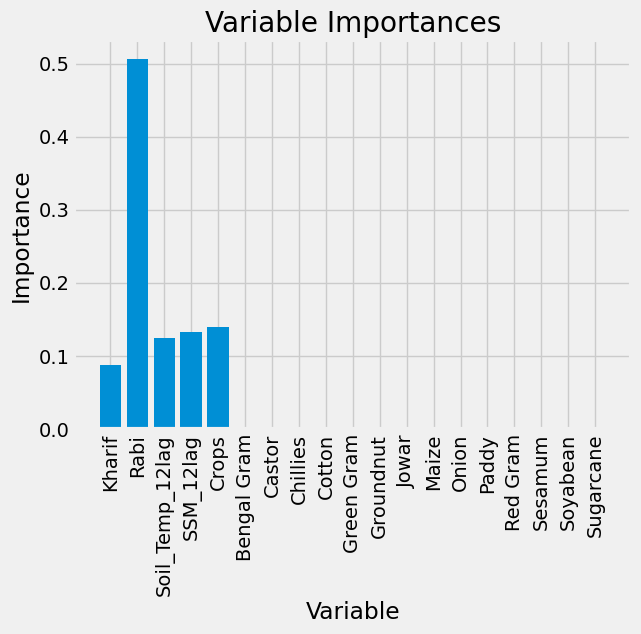

In [1636]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
# Set the style
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, optimal_features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

In [1637]:
mandal_name = 'Yellandu'

test_mandal = test[test['Mandal_Nam'] == mandal_name]

predictions_mandal = rf.predict(np.array(test_mandal[optimal_features]))

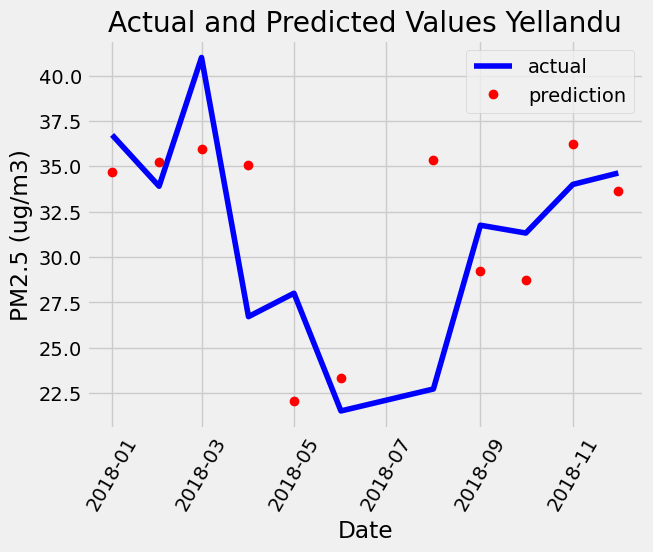

In [1638]:
# Dates of training values
months = np.array(test_mandal['Month'])
days = np.empty(len(months))
days.fill(1)
years = np.array(test_mandal['Year'])

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': test_mandal[optimal_predictor]})

# Dates of predictions
months = np.array(test_mandal['Month'])
days = np.empty(len(months))
days.fill(1)
years = np.array(test_mandal['Year'])

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions_mandal})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel(optimal_predictor); plt.title('Actual and Predicted Values ' + mandal_name)
plt.show()